# Analysis of Public Interest on Initial Public Offering (IPO) on Bursa Malaysia

Initial Public Offering (IPO) is where shares of a company are offered to investors, both institutional and the public.

Here I look at public interest towards IPO on Bursa Malaysia over years 2017 till 2022.

Data was collected from the Internet 2017 till 2022. Sources are online only, including Bursa Malaysia, The Edge websites and many more.

Data was collected manually, hence there could be errors in the numbers - read that again - data was collected manually, hence there could be errors in the numbers. I also made no effort to verify the data after initial collection.

Only IPOs that could be subscribed by the public in the Main and ACE markets was included, e.g IPOs on the LEAP market or IPOs or ETFs were not included. 

<b>This exercise is for entertainment purpose only. Do not trade shares based on this exercise. Trading shares involve capital loss and emotional pain. Please consult your investment advisor before embarking on any financial exercise.</b>

In [90]:
import pandas as pd
from statistics import stdev
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [91]:
df = pd.read_csv("IPO_2017to2022.csv")
df.head()

,TICKER,MARKET,YEAR,LISTPRICE,VOLUMEIPODAY,OPENPRICEIPODAY,HIGHESTPRICEIPODAY,CLOSINGPRICEIPODAY,NEWSHARES,TOTALAPPLICATIONS,...,XBUMIAPPLICATIONS,XBUMIAPPLICATIONSHARES,XBUMIBALLOTINGOSCBED,ELIGPERSONSSHARES,PVPLACEMENTSHARES,OFFERFORSALE,CAPITALRAISED,PUBLICISSUENEWSHARES,ENLARGEDSHARECAPITAL,MARKETCAPONLISTING
0,CORAZA,ACE,2022,0.28,1937841.0,0.700,0.705,0.645,2140000.0,26781.0,...,14299.0,1.850000e+09,171.40,21400000.0,96400000.0,21400000.0,33000000.0,117800000.0,428300000.0,119900000.0
1,SENHENG,MAIN,2022,1.07,NaN,NaN,NaN,NaN,30000000.0,16548.0,...,9679.0,2.499200e+08,15.66,22500000.0,149500000.0,139500000.0,NaN,250000000.0,NaN,NaN
2,TUJUSETIA,MAIN,2021,0.70,1145707.0,0.775,0.875,0.740,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YENHER,MAIN,2021,0.95,618271.0,0.995,1.000,0.900,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CTOS,MAIN,2021,1.10,3663593.0,1.500,1.760,1.620,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that here many columns such as NEWSHARES and TOTALAPPLICATIONS are not populated, as they are used in this current analysis.

### Feature Engineering and Data Clean-Up

In [92]:
# drop rows if stock hasn't IPOed yet
df = df[df['VOLUMEIPODAY'].notna()]

In [93]:
# Create following columns:
# % difference between list price vs opening price on IPO day
# % difference between list price vs highest price on IPO day
# % difference between opening price on IPO day vs closing price on IPO day
# % difference between opening price on IPO day vs highest price on IPO day

df['LISTVSOPENING_PCT'] = df['OPENPRICEIPODAY']/df['LISTPRICE']*100 - 100
df['LISTVSHIGHEST_PCT'] = df['HIGHESTPRICEIPODAY']/df['LISTPRICE']*100 - 100
df['LISTVSCLOSING_PCT'] = df['CLOSINGPRICEIPODAY']/df['LISTPRICE']*100 - 100

In [94]:
# remove Lotte Chemical as it was undersubscribed
df = df[df['TICKER']!='LOTTE']

In [95]:
df.shape

(65, 28)

In [96]:
# grab all available years
years = df['YEAR'].unique().tolist()[::-1]
years

[2017, 2018, 2019, 2020, 2021, 2022]

## Measuring Subscription Interest: Oversubscription Rate by Year

I first ask this question: how does public interest towards IPOs change over the years? I am interested in this question since I have encountered anecdotes from acquaintances and friends that it is getting harder to get any units from IPO offering since past years.

### Oversubscription Rate By Listing Price: For listing price less than, versus at least, RM1

In [110]:
# function to calculate bar height, bar error bars and counts, after dividing by RM<1 and RM>=1

def calculate_bardata(years, df, targetvar):

    barheight = {}
    barheight['lt1'] = {}
    barheight['mt1'] = {}

    barerr = {}
    barerr['lt1'] = {}
    barerr['mt1'] = {}

    count = {}
    count['lt1']={}
    count['mt1']={}

    for year in years:
        # for < RM1
        df_series_lt1 = df[((df['YEAR']==year)  & (df['LISTPRICE']<1))][targetvar]

        count['lt1'][year] = df_series_lt1.count()
        mean_year_lt1 = round(df_series_lt1.mean(),2)

        barheight['lt1'][year] = mean_year_lt1
        if df_series_lt1.count() >1:
            barerr['lt1'][year] = round(stdev(df_series_lt1),2)
        else:
            barerr['lt1'][year] = 0

        df_series_mt1 = df[((df['YEAR']==year)  & (df['LISTPRICE']>=1))][targetvar]

        count['mt1'][year] = df_series_mt1.count()
        mean_year_mt1 = round(df_series_mt1.mean(),2)

        barheight['mt1'][year] = mean_year_mt1
        if df_series_mt1.count() >1:
            barerr['mt1'][year] = round(stdev(df_series_mt1),2)
        else:
            barerr['mt1'][year] = 0
            
    return count, barheight, barerr

In [111]:
count, barheight, barerr = calculate_bardata(years, df, 'TOTALBALLOTINGOSCBED')

In [112]:
print("For listing price <= RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price > RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))


For listing price <= RM1:
2017(7): mean 36.03, stdev 23.4
2018(10): mean 18.15, stdev 13.09
2019(13): mean 13.3, stdev 8.81
2020(10): mean 30.98, stdev 25.01
2021(14): mean 75.15, stdev 53.15
2022(1): mean 132.5, stdev 0

For listing price > RM1:
2017(3): mean 6.34, stdev 2.3
2018(1): mean 1.16, stdev 0
2019(2): mean 4.01, stdev 0.53
2020(1): mean 3.91, stdev 0
2021(3): mean 22.23, stdev 4.68
2022(0): mean nan, stdev 0


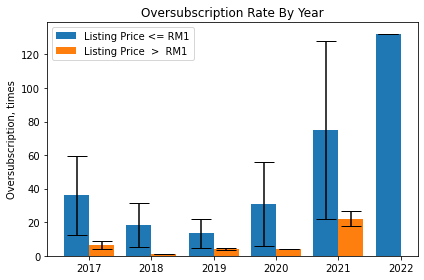

In [106]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Oversubscription, times')
plt.title('Oversubscription Rate By Year')
plt.legend(["Listing Price <= RM1", "Listing Price  >  RM1"])

plt.tight_layout()
plt.show()

---WRITE OBSERVATION HERE-------

## Measuring Speculative Activity on IPO Day: Volume on IPO day by Year
Question: If there is an increase in public interest, does this translate into higher trading volume on the counter on IPO day?
Potential scenario is that there are more capital/participants involved on the counter on the IPO day, other than those originally succesfully subscribed to the IPO.

### Aggregate, all combined (regardless listing price)

In [113]:
count, barheight, barerr = calculate_bardata(years, df, 'VOLUMEIPODAY')

In [114]:
print("For listing price <= RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price > RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))


For listing price <= RM1:
2017(7): mean 1178970.71, stdev 1000184.04
2018(10): mean 1010671.4, stdev 591685.52
2019(13): mean 1644805.92, stdev 1310669.49
2020(10): mean 2046393.3, stdev 750481.12
2021(14): mean 1583495.0, stdev 849490.25
2022(1): mean 1937841.0, stdev 0

For listing price > RM1:
2017(3): mean 282241.67, stdev 339303.22
2018(1): mean 736832.0, stdev 0
2019(2): mean 1325753.0, stdev 1171305.41
2020(1): mean 4101546.0, stdev 0
2021(3): mean 2373199.0, stdev 1126551.55
2022(0): mean nan, stdev 0


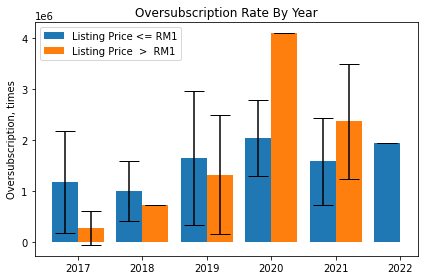

In [115]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Oversubscription, times')
plt.title('Oversubscription Rate By Year')
plt.legend(["Listing Price <= RM1", "Listing Price  >  RM1"])

plt.tight_layout()
plt.show()

2020 seems to be the year with the most liquidity, despite being not the year with the highest oversubscription rate

## Measuring Speculative Activity on IPO Day: % Difference between Listing vs Opening Price

In [123]:
count, barheight, barerr = calculate_bardata(years, df, 'LISTVSOPENING_PCT')
print("For listing price <= RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price > RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))

For listing price <= RM1:
2017(7): mean 22.94, stdev 8.69
2018(10): mean 33.56, stdev 39.76
2019(13): mean 26.13, stdev 32.24
2020(10): mean 55.9, stdev 58.98
2021(14): mean 69.53, stdev 80.09
2022(1): mean 150.0, stdev 0

For listing price > RM1:
2017(3): mean 6.17, stdev 5.58
2018(1): mean -2.11, stdev 0
2019(2): mean 0.14, stdev 2.37
2020(1): mean 0.0, stdev 0
2021(3): mean 14.96, stdev 18.54
2022(0): mean nan, stdev 0


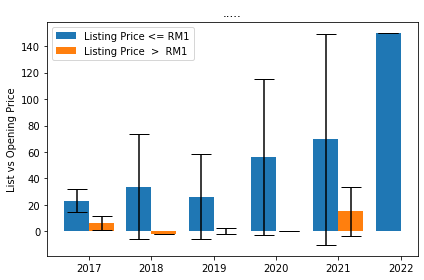

In [122]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('List vs Opening Price')
plt.title('.....')
plt.legend(["Listing Price <= RM1", "Listing Price  >  RM1"])

plt.tight_layout()
plt.show()

There is a general trend that over the years, we can see higher price at market open compared to previous years

## Measuring Speculative Activity on IPO Day: % Difference between Listing vs Highest Price

In [124]:


count, barheight, barerr = calculate_bardata(years, df, 'LISTVSHIGHEST_PCT')

print("For listing price <= RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price > RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))

For listing price <= RM1:
2017(7): mean 29.21, stdev 5.87
2018(10): mean 55.07, stdev 59.8
2019(13): mean 34.83, stdev 37.87
2020(10): mean 75.74, stdev 62.62
2021(14): mean 84.84, stdev 86.37
2022(1): mean 151.79, stdev 0

For listing price > RM1:
2017(3): mean 8.06, stdev 5.39
2018(1): mean 14.79, stdev 0
2019(2): mean 15.24, stdev 9.99
2020(1): mean 12.5, stdev 0
2021(3): mean 35.25, stdev 25.15
2022(0): mean nan, stdev 0


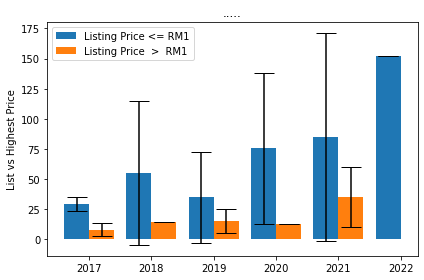

In [126]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('List vs Highest Price')
plt.title('.....')
plt.legend(["Listing Price <= RM1", "Listing Price  >  RM1"])

plt.tight_layout()
plt.show()

Also, there is a general trend we can see higher price at during trading day compared to previous years.

## Does high public interest during subscription translate into higher activity on IPO day?

In [72]:
# drop 2022 as we no IPOs yet
df = df[df['YEAR']!=2022]

### Plot oversubscription vs volume

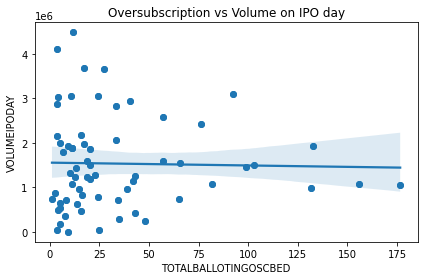

In [129]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'VOLUMEIPODAY'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
    
plt.title('Oversubscription vs Volume on IPO day')
plt.tight_layout()
plt.show()

In [130]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,4))

R2:  -0.0236
P-value:  0.8523
stderr:  3374.1522


Doesn't look like there's any correlation: high interest in subscription activity does not translate into high volume on IPO day per se.

## Does high public interest during subscription translate into higher speculative activity on IPO day?
i.e, does high public interest push up the price (despite having no increase in volume)?

### Plot oversubscription vs %difference listing-to-opening price

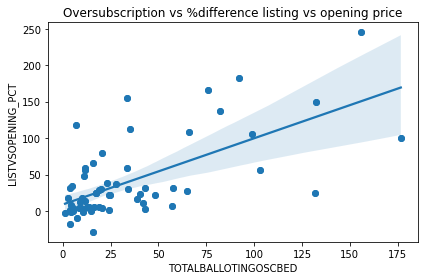

In [131]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSOPENING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs opening price')
plt.tight_layout()
plt.show()

In [132]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.6531
P-value: 3.7184e-09
stderr:  0.1327
equation: y = 0.9084*X + 8.9458


Looks like there's a correlation: the higher public interest in subscribing to the IPO (as measured by the oversubscription rate), the higher likelihood that we'd see higher opening price on IPO day.

This tells you that while there is no correlation between oversubscription with volume per se, the ones that participate during IPO day indeed push up the price at market open.

##### Remove points with oversubscription more than 40X, to see if the result is robust for lower oversubscription data points

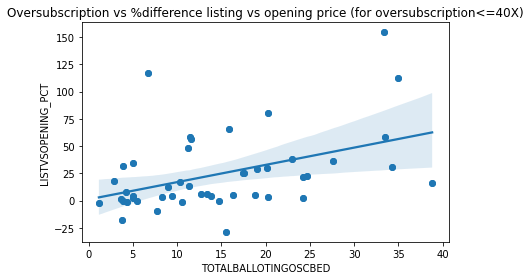

In [133]:
df2 = df[df['TOTALBALLOTINGOSCBED']<40]

x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSOPENING_PCT'
x = df2[x_label]
y = df2[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs opening price (for oversubscription<=40X)')
plt.tight_layout()
plt.show()


In [134]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.4376
P-value: 2.0994e-03
stderr:  0.4849
equation: y = 1.5829*X + 1.1793


Yes, the result still holds, albeit with slightly lower R2 value.

### Plot oversubscription vs %difference listing-to-highest price

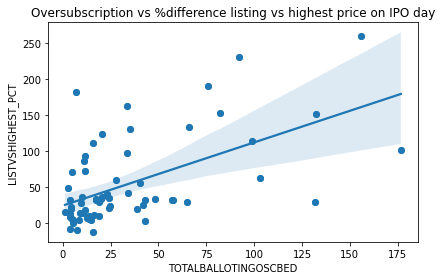

In [135]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSHIGHEST_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs highest price on IPO day')
plt.tight_layout()
plt.show()

In [136]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.564
P-value: 9.9819e-07
stderr:  0.1621
equation: y = 0.8786*X + 23.9991


Also, the higher public interest in subscribing to the IPO (as measured by the oversubscription rate), the higher likelihood that the price will be pushed to a really high level on IPO day.

So, again, high public interest to the IPO does not translate into more volume, but those that participate during the IPO day push up the price at market open, and also push up the price to a high level during the day.

#### Again, check for oversubscription less than 40X

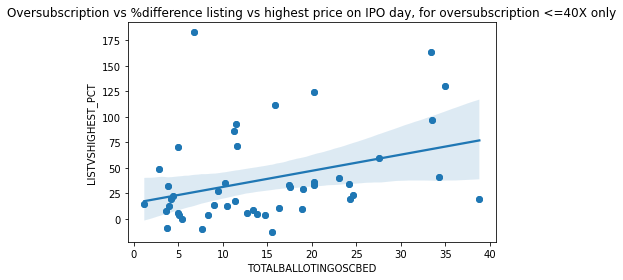

In [137]:
df2 = df[df['TOTALBALLOTINGOSCBED']<=40]
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSHIGHEST_PCT'
x = df2[x_label]
y = df2[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs highest price on IPO day, for oversubscription <=40X only')
plt.tight_layout()
plt.show()

In [138]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.3455
P-value:  0.0174
stderr:  0.6392
equation: y = 1.5789*X + 15.6509


Result holds

### plot oversubscription vs %difference listing-to-closing price

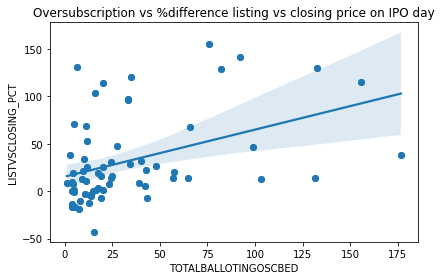

In [139]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSCLOSING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs closing price on IPO day')
plt.tight_layout()
plt.show()

In [140]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.4183
P-value: 5.2486e-04
stderr:  0.1357
equation: y = 0.4959*X + 15.3457


So, again, high public interest to the IPO does not translate into more volume, but those that participate during the IPO day push up the price at market open, and also push up the price to a high level during the day.

#### Verify for oversubscription less than 40X

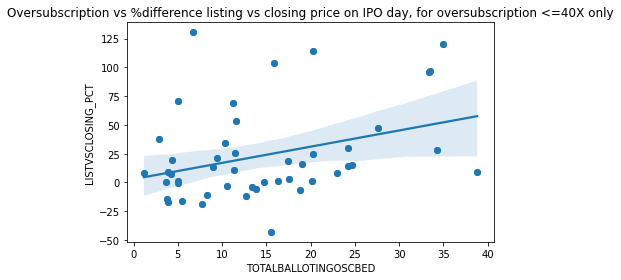

In [141]:
df = df[df['TOTALBALLOTINGOSCBED']<=40]
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSCLOSING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs closing price on IPO day, for oversubscription <=40X only')
plt.tight_layout()
plt.show()

In [142]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.3451
P-value:  0.0175
stderr:  0.5712
equation: y = 1.409*X + 2.9492


Result holds, albeit with bit worse P-value.

## Summary
1. There's more interest from the public for IPO in recent years
    - with a general trend that we see higher price at market open and during trading day vs previous years.
2. Year 2020 we see the market is flush with liquidity, as there is high volume on an IPO counter.
3. Higher oversubscription rate does not translate into higher volume on IPO day
4. Yet, higher oversubscription rate correlates with:
    - higher price at market open
    - higher price during trading day
    - higher price at market close

## More Questions
1. The higher interest from the public, is it both from the Bumis as well as non-Bumis?
2. ...
3. ...